In [42]:
import xarray as xr
import rioxarray as rxr

# 1. Open the GeoTIFF
# Use rioxarray to read a single-band or multi-band GeoTIFF. 'masked=True' applies nodata mask if present.
da = rxr.open_rasterio('input/rast_gdpTot_1990_2020_30arcsec.tif', masked=True)

# If you prefer working with an xarray Dataset, convert the DataArray to a Dataset and give it a meaningful name:
ds = da.to_dataset(name='GDP_PPP')

# 2. Print a summary of the dataset
print("=== DATASET SUMMARY ===")
print(ds)
# Shows dims, coords, data_vars, attrs

# 3. Print just dimensions and their sizes
print("\n=== DIMENSIONS ===")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

# 4. Print all coordinates
print("\n=== COORDINATES ===")
for coord in ds.coords:
    vals = ds.coords[coord].values
    preview = vals[:5] if vals.size > 5 else vals
    print(f"  {coord}: values = {preview}{'...' if vals.size > 5 else ''}")

# 5. Print each data variable’s dims and shape
print("\n=== DATA VARIABLES ===")
for var_name in ds.data_vars:
    var = ds[var_name]
    print(f"  {var_name}: dims={var.dims}, shape={var.shape}, attrs={var.attrs}")

# 6. Inspect the time axis specifically (if present)
if 'time' in ds.coords:
    print("\n=== TIME COORDINATE ===")
    print("Values:", ds['time'].values)
    print("dtype :", ds['time'].dtype)
    try:
        print("Units :", ds['time'].attrs.get('units'))
    except AttributeError:
        pass

=== DATASET SUMMARY ===
<xarray.Dataset> Size: 26GB
Dimensions:      (band: 7, x: 43202, y: 21384)
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 171kB 89.1 89.09 89.08 ... -89.08 -89.09 -89.1
    spatial_ref  int64 8B 0
Data variables:
    GDP_PPP      (band, y, x) float32 26GB ...

=== DIMENSIONS ===
  band: 7
  x: 43202
  y: 21384

=== COORDINATES ===
  band: values = [1 2 3 4 5]...
  x: values = [-180.00374926 -179.99541593 -179.9870826  -179.97874926 -179.97041593]...
  y: values = [89.09541651 89.08708318 89.07874984 89.07041651 89.06208318]...
  spatial_ref: values = 0

=== DATA VARIABLES ===
  GDP_PPP: dims=('band', 'y', 'x'), shape=(7, 21384, 43202), attrs={'AREA_OR_POINT': 'Area', 'STATISTICS_MAXIMUM': 3133778944, 'STATISTICS_MEAN': -9999, 'STATISTICS_MINIMUM': 0, 'STATISTICS_STDDEV': -9999, 'scale_factor': 1.0, 'add_offset': 0.0, 'long_name': ('gdp_1990', 

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_2606/334420271.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for dim, size in ds.dims.items():


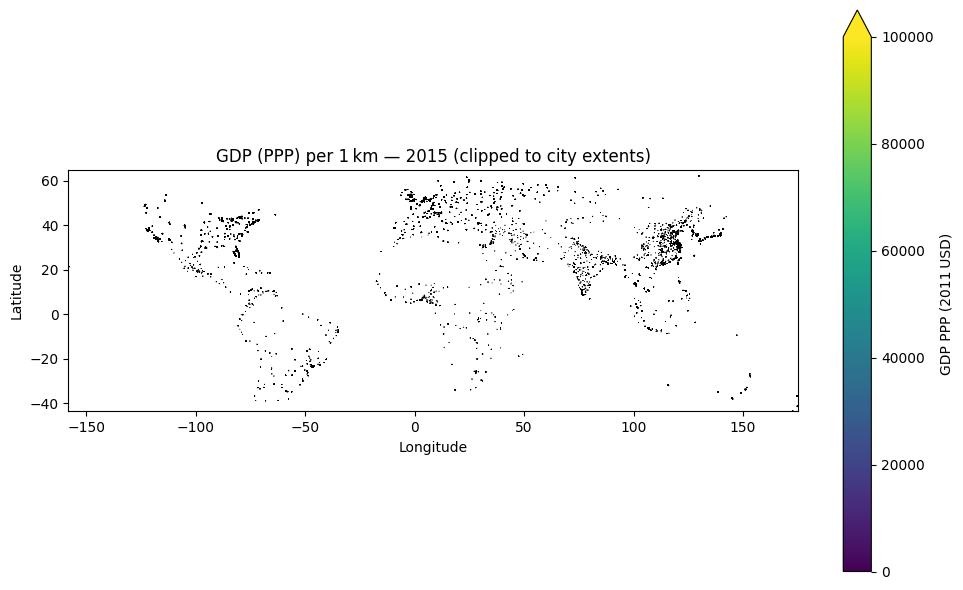

In [ ]:
import xarray as xr
import rioxarray as rxr  # pip install rioxarray
import geopandas as gpd  # pip install geopandas
import matplotlib.pyplot as plt

# 1. Open the GeoTIFF
#    Reads a multi-band raster where bands correspond to different years
da = rxr.open_rasterio('input/rast_gdpTot_1990_2020_30arcsec.tif', masked=True)

# 2. Convert to Dataset (optional) and select the 2015 slice
#    Bands 1–7 map to years 1990, 1995, 2000, 2005, 2010, 2015, 2020 respectively
ds = da.to_dataset(name='GDP_PPP')
gdp2020 = ds['GDP_PPP'].sel(band=7)

# 3. Assign a CRS so rioxarray can interpret coordinates
gdp2020 = gdp2020.rio.write_crs("EPSG:4326", inplace=True)

# 4. Load the city‑extent shapefile
cities = gpd.read_file('input/Morphological_Urban_Area_SSP_all.shp')

# 5. Reproject city geometries to match the raster CRS
cities = cities.to_crs(gdp2020.rio.crs)

# 6. Clip the raster to your cities
#    Outside polygons become NaN; 'drop=True' trims the array to the extents
gdp_cities = gdp2020.rio.clip(
    geometries=cities.geometry.values,
    crs=cities.crs,
    drop=True
)

# 7. Plot the clipped GDP raster with city boundaries overlay
plt.figure(figsize=(10, 6))
gdp_cities.plot(
    cmap='viridis',
    vmin=0, vmax=1e5,   # adjust to your data range
    cbar_kwargs={'label': 'GDP PPP (2011 USD)'}
)
cities.boundary.plot(
    ax=plt.gca(),
    edgecolor='black', linewidth=0.5
)
plt.title("GDP (PPP) per 1 km — 2015 (clipped to city extents)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_26978/97191177.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cities['centroid'] = cities.geometry.centroid
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_26978/97191177.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cities_eur = cities[cities.centroid.within(eur_bbox)].copy()


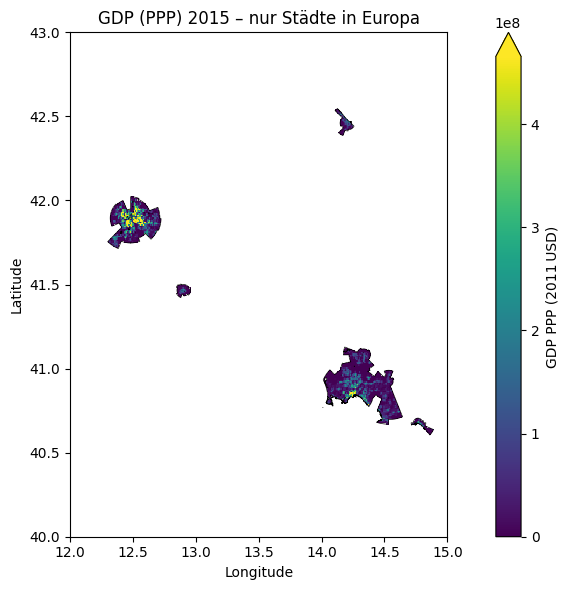

In [2]:
import xarray as xr
import rioxarray as rxr  # pip install rioxarray         # pip install rioxarray
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# 1. Lade GDP‑Raster und wähle 2015
da = rxr.open_rasterio('input/rast_gdpTot_1990_2020_30arcsec.tif', masked=True)

# 2. Convert to Dataset (optional) and select the 2015 slice
#    Bands 1–7 map to years 1990, 1995, 2000, 2005, 2010, 2015, 2020 respectively
ds = da.to_dataset(name='GDP_PPP')
gdp2020 = ds['GDP_PPP'].sel(band=7)

# 2. Schreibe CRS auf das DataArray
gdp2020 = gdp2020.rio.write_crs("EPSG:4326", inplace=True)

# 3. Lade alle Städte
cities = gpd.read_file('input/Morphological_Urban_Area_SSP_all.shp')

# 4. Definiere grobe Europa‑Bounding‑Box
lon_min, lon_max = 12, 15
lat_min, lat_max = 40, 43
eur_bbox = box(lon_min, lat_min, lon_max, lat_max)

# 5. Filter Städte, die in Europa liegen
#    (wir checken, ob der Mittelpunkt im BBox liegt)
cities = cities.to_crs("EPSG:4326")
cities['centroid'] = cities.geometry.centroid
cities_eur = cities[cities.centroid.within(eur_bbox)].copy()

# 6. Clippe das Raster nur auf diese europäischen Städte
gdp_eur_cities = gdp2020.rio.clip(
    geometries=cities_eur.geometry.values,
    crs=cities_eur.crs,
    drop=True
)

# 7. Plot
plt.figure(figsize=(10, 6))
ax = plt.gca()
gdp_eur_cities.plot(
    ax=ax,
    cmap='viridis',
    robust=True,
    cbar_kwargs={'label': 'GDP PPP (2011 USD)'}
)
# Grenzen der Städte überlagern
cities_eur.boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)
# Bounding‑Box als Rahmen (optional)
x0, y0, x1, y1 = eur_bbox.bounds
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)

ax.set_title("GDP (PPP) 2015 – nur Städte in Europa")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


In [3]:
import rioxarray as rxr  # pip install rioxarray
from rasterstats import zonal_stats  # pip install rasterstats
import geopandas as gpd  # pip install geopandas

# 1. Load city‑extent shapefile
cities = gpd.read_file('input/Morphological_Urban_Area_SSP_all.shp')

# 2. Ensure shapefile is in the same CRS as the raster
#    GeoTIFF is EPSG:4326 by earlier steps
cities = cities.to_crs("EPSG:4326")

# 3. Compute zonal sum of GDP PPP for 2015
#    Bands in the TIFF: 1→1990, 2→1995, 3→2000, 4→2005, 5→2010, 6→2015, 7→2020
stats = zonal_stats(
    vectors=cities.geometry,
    raster='input/rast_gdpTot_1990_2020_30arcsec.tif',
    band=7,            # select 2015
    stats=['sum'],
    all_touched=False, # only pixels whose center falls within the polygon
    geojson_out=False   # return list of dicts, not full GeoJSON
)

# 4. Attach results back to GeoDataFrame
cities['gdp_ppp_sum_2020'] = [feat['sum'] for feat in stats]

# 5. Inspect results
print(cities[['Aggname', 'gdp_ppp_sum_2020']])


                             Aggname  gdp_ppp_sum_2020
0                           Winnipeg      3.884632e+10
1                            Calabar      2.103352e+09
2                              Anqiu      1.096581e+10
3                            Maracay      5.863038e+09
4     Tel Aviv-Yafo (Tel Aviv-Jaffa)      1.388404e+11
...                              ...               ...
1564                   Florianópolis      1.937530e+10
1565                             Fès      9.351290e+09
1566                 San Luis Potosí      2.678187e+10
1567                  Köln (Cologne)      4.054104e+10
1568                            Lomé      6.750969e+09

[1569 rows x 2 columns]


In [ ]:
import pandas as pd
cities_temp = pd.read_csv('cities_temp_diff_data_SSP5.csv')

Index(['City', 'Mean_1981_2010', 'Mean_2071_2100', 'Temp_Diff_2071_2100',
       'Continent'],
      dtype='object')


In [36]:
merged = pd.merge(
    cities,
    cities_temp,
    how='left',              # or 'inner', 'right', etc. depending on what you need
    left_on='Aggname',       # column in `cities`
    right_on='City'          # column in `cities_temp`
)
# (optional) drop the now‑redundant City column:
merged = merged.drop('City', axis=1)



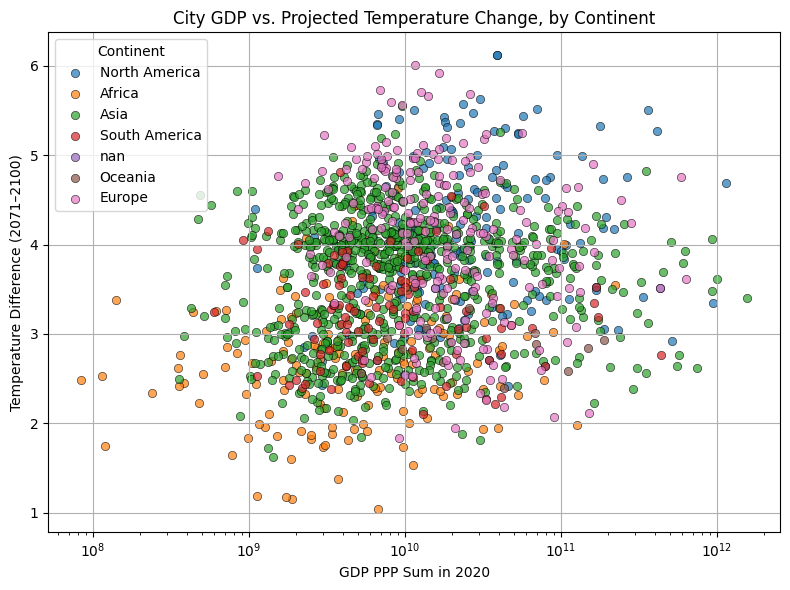

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

for cont in merged['Continent'].unique():
    sub = merged[merged['Continent'] == cont]
    ax.scatter(
        sub['gdp_ppp_sum_2020'],
        sub['Temp_Diff_2071_2100'],
        label=cont,
        alpha=0.7,
        edgecolor='k',
        linewidth=0.5
    )

ax.set_xlabel('GDP PPP Sum in 2020')
ax.set_ylabel('Temperature Difference (2071–2100)')
ax.set_title('City GDP vs. Projected Temperature Change, by Continent')
ax.set_xscale('log')
ax.grid(True)
ax.legend(title='Continent')
plt.tight_layout()
plt.show()



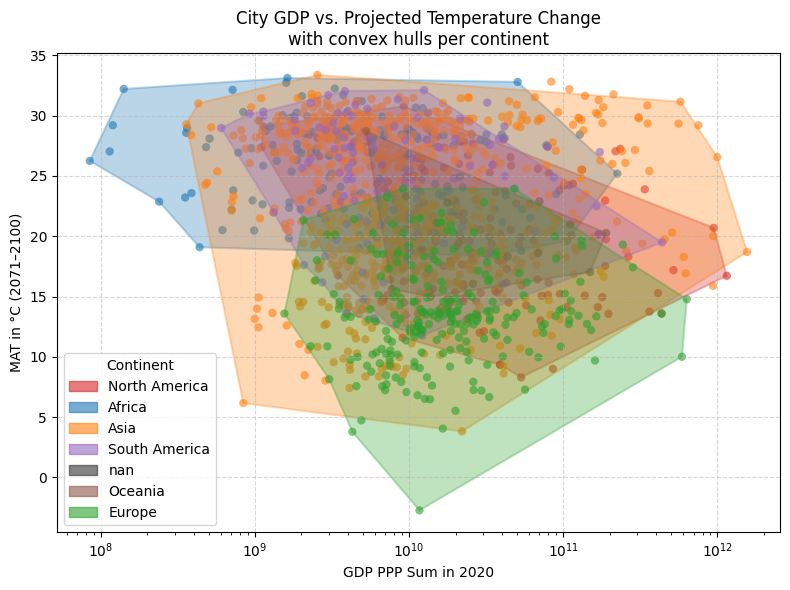

In [38]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint
from matplotlib.patches import Polygon, Patch
import numpy as np

# Eigene Farbpalette pro Kontinent
continent_palette = {
    'Africa':        '#1f77b4',
    'Asia':          '#ff7f0e',
    'Europe':        '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania':       '#8c564b'
}

fig, ax = plt.subplots(figsize=(8, 6))

# Einzigartige Kontinente aus den Daten
continents = merged['Continent'].unique()

# Punkte und konvexe Hüllen pro Kontinent
for cont in continents:
    sub = merged[merged['Continent'] == cont]
    x = sub['gdp_ppp_sum_2020'].values
    y = sub['Mean_2071_2100'].values  # oder 'Temp_Diff_2071_2100'
    color = continent_palette.get(cont, '#333333')  # Fallback-Farbe

    # Scatter-Plot
    ax.scatter(x, y, color=color, alpha=0.6, edgecolor='none')

    # Konvexe Hülle zeichnen, falls >=3 Punkte
    if len(x) >= 3:
        hull = MultiPoint(np.column_stack((x, y))).convex_hull
        poly = Polygon(
            np.array(hull.exterior.coords),
            facecolor=color,
            edgecolor=color,
            alpha=0.3,
            linewidth=1.5
        )
        ax.add_patch(poly)

# Log-Skala auf der x-Achse
ax.set_xscale('log')

# Beschriftungen und Titel
ax.set_xlabel('GDP PPP Sum in 2020')
ax.set_ylabel('MAT in °C (2071–2100)')
ax.set_title('City GDP vs. Projected Temperature Change\nwith convex hulls per continent')
ax.grid(True, linestyle='--', alpha=0.5)

# Legend-Proxies per Patch
handles = [
    Patch(facecolor=continent_palette.get(cont, '#333333'),
          edgecolor=continent_palette.get(cont, '#333333'),
          label=cont,
          alpha=0.6)
    for cont in continents
]
ax.legend(handles=handles, title='Continent', loc='best')

plt.tight_layout()
plt.show()


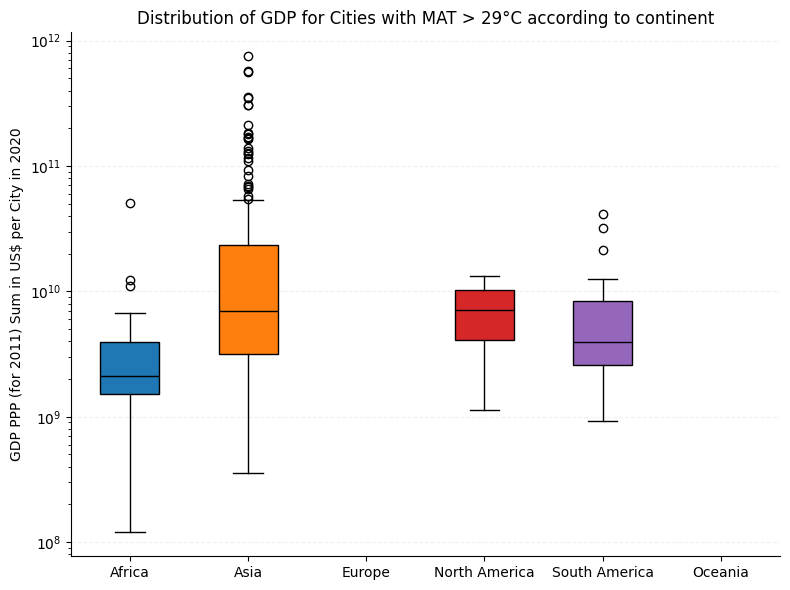

In [42]:
import matplotlib.pyplot as plt

# Farben für die Kontinente festlegen
continent_palette = {
    'Africa':       '#1f77b4',
    'Asia':         '#ff7f0e',
    'Europe':       '#2ca02c',
    'North America':'#d62728',
    'South America':'#9467bd',
    'Oceania':      '#8c564b'
}

# 1) Filtere alle Städte mit Mean > 29°C
hot_cities = merged[merged['Mean_2071_2100'] > 29]

# 2) Figure und Achse anlegen
fig, ax = plt.subplots(figsize=(8, 6))

# 3) Boxplot pro Kontinent (GDP), ohne Notches und ohne Fliers
for i, (continent, color) in enumerate(continent_palette.items()):
    continent_data = hot_cities[hot_cities['Continent'] == continent]['gdp_ppp_sum_2020']
    ax.boxplot(
        continent_data,
        positions=[i],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=color, color='black'),
        medianprops=dict(color='black'),
        showfliers=True
    )

# 4) Achsenbeschriftungen und Titel
ax.set_xticks(range(len(continent_palette)))
ax.set_xticklabels(continent_palette.keys(), rotation=0)
ax.set_ylabel('GDP PPP (for 2011) Sum in US$ per City in 2020')
ax.set_yscale('log')
ax.set_title('Distribution of GDP for Cities with MAT > 29°C according to continent')

# 5) Styling: keine obere/rechte Achse, feines Y‑Grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, axis='y', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()
